# Analisis de discriminante y k-vecinos

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets

In [88]:
data = sklearn.datasets.load_iris(as_frame=True);
df = data['data']

df = df.drop(columns=['petal length (cm)', 'petal width (cm)'])
df['species'] = data['target']
# 0: 'setosa', 1: 'versicolor', 2: 'virginica'
df

,sepal length (cm),sepal width (cm),species
0,5.1,3.5,0
1,4.9,3.0,0
2,4.7,3.2,0
3,4.6,3.1,0
4,5.0,3.6,0
...,...,...,...
145,6.7,3.0,2
146,6.3,2.5,2
147,6.5,3.0,2
148,6.2,3.4,2


Text(0, 0.5, 'Ancho del Sépalo (cm)')

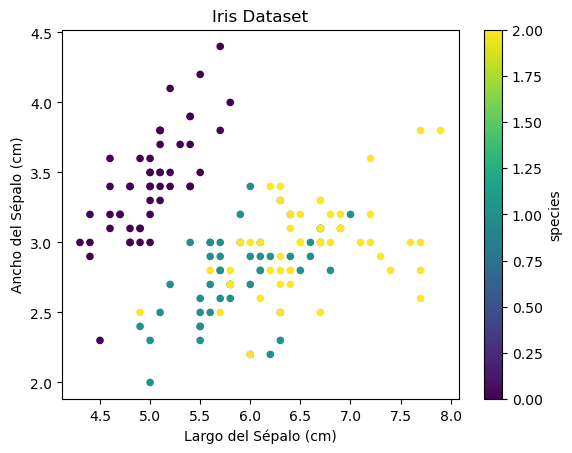

In [89]:
scatter = df.plot.scatter(x='sepal length (cm)', y='sepal width (cm)', c='species', colormap='viridis')
plt.title('Iris Dataset')
plt.xlabel('Largo del Sépalo (cm)')
plt.ylabel('Ancho del Sépalo (cm)')

In [90]:
X_np = df[['sepal length (cm)', 'sepal width (cm)']].to_numpy()
y_np = df['species'].to_numpy()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_np, y_np, train_size = 0.7, test_size=0.3, random_state=0)


print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (105, 2)
X_test shape: (45, 2)
y_train shape: (105,)
y_test shape: (45,)


In [91]:
from scipy.special import softmax

class LDA:
    def __init__(self):
        self.clases = None
        self.mu_k = {}
        self.c_k = {}
        self.sigma = None
        self.sigma_inv = None
        self.w = {}
        self.b = {}


    def fit(self, X, y):
        # Convertir y a 1D si es necesario
        self.clases = np.unique(y)
        n_clases = len(self.clases)
        n_muestras = X.shape[0]

        self.D_k = {}
        self.c_k = {}
        self.mu_k = {}
        self.sigma_k = {}
        total_sigma = np.zeros((X.shape[1], X.shape[1]))  # para acumular Σ

        for k in self.clases:
            D_k = X[y == k]
            self.D_k[k] = D_k
            self.c_k[k] = len(D_k) / n_muestras
            self.mu_k[k] = np.mean(D_k, axis=0)
            self.sigma_k[k] = np.cov(D_k.T, bias=False)  # dividimos por |Dk| - 1

            # Acumular para el cálculo de Σ (la covarianza global)
            total_sigma += (len(D_k) - 1) * self.sigma_k[k]

        self.sigma = total_sigma / (n_muestras - n_clases)
        self.sigma_inv = np.linalg.inv(self.sigma)

        # Cálculo de w_y y b_y para cada clase
        self.w = {}
        self.b = {}
        for k in self.clases:
            mu = self.mu_k[k]
            c = self.c_k[k]
            self.w[k] = self.sigma_inv @ mu
            self.b[k] = -0.5 * mu.T @ self.sigma_inv @ mu + np.log(c)

        return self

    def predict_proba(self, X):
        scores = np.array([X @ self.w[k] + self.b[k] for k in self.clases])  # (K, n_muestras)
        probs = softmax(scores, axis=0).T  # Transponemos para (n_muestras, K)
        return probs

    def predict(self, X):
        probs = self.predict_proba(X)
        return self.clases[np.argmax(probs, axis=1)]


In [92]:
clasificador = LDA()
clasificador.fit(X_train, y_train)
y_pred = clasificador.predict(X_test)

# Imprimir resultados para verificar
print("Predicciones:", y_pred)
print("Exactitud:", np.mean(y_pred == y_test))


Predicciones: [1 1 0 2 0 2 0 2 2 1 1 2 1 2 1 0 1 1 0 0 1 1 0 0 1 0 0 1 1 0 2 1 0 1 2 1 0
 1 1 1 2 0 2 0 0]
Exactitud: 0.8


TypeError: Ellipse.__init__() takes 4 positional arguments but 5 were given

<Figure size 1000x600 with 0 Axes>

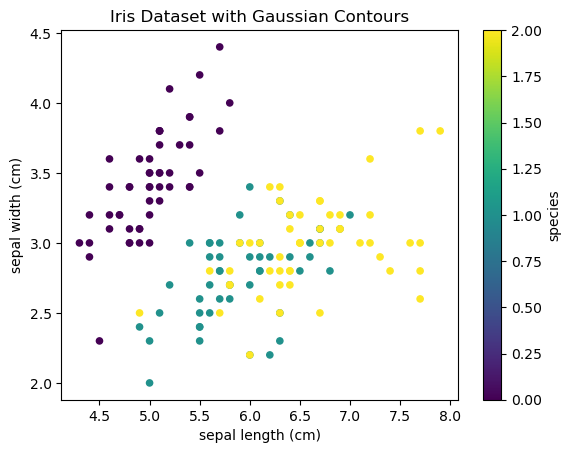

In [93]:
# Superponer las medias y las covarianzas de cada gaussiana
from matplotlib.patches import Ellipse
def plot_gaussian_contours(ax, mean, cov, color):
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    order = eigenvalues.argsort()[::-1]
    eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]

    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    width, height = 2 * np.sqrt(eigenvalues)  # Escala de 2 desviaciones estándar

    ellipse = Ellipse(mean, width, height, angle, edgecolor=color, facecolor='none', linewidth=2)
    ax.add_patch(ellipse)


# Graficar las gaussianas
plt.figure(figsize=(10, 6))
ax = df.plot.scatter(x='sepal length (cm)', y='sepal width (cm)', c='species', colormap='viridis')
plt.title('Iris Dataset with Gaussian Contours')
colors = ['red', 'blue', 'green']
for i, k in enumerate(clasificador.clases):
    mean = clasificador.mu_k[k]
    cov = clasificador.sigma
    plot_gaussian_contours(ax, mean, cov, colors[i])

plt.show()